In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit

In [3]:
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

# Magic Squares

A magic square of order $n \in \mathbb{N}$ is a square formation of the numbers $1, 2, \ldots, n^2$ such that

* each row,
* each column,
* and each diagonal

sum up to the same number. This same number is called the **magic constant** and can be determined by

$$
M = n\,(n^2 + 1) \,/\, 2,
$$

which is the sum of all the numbers in the magic square divided by $n$. 


### Example

For instance if $n=3$, then an exemplary magic square is given by

$$
\begin{bmatrix}
8 & 1 & 6 \\
3 & 5 & 7 \\
4 & 9 & 2 
\end{bmatrix}
$$

with the magic constant $M = 15$. Let's test this using the function

$$
Q(x) = \sum_{\text{row}=1}^{n} |\text{row}(x) - M| + \sum_{\text{col}=1}^{n} |\text{col}(x) - M| + \sum_{\text{diag}=1}^{2} |\text{diag}(x) - M|
$$

which measures the deviation to a being a magic square. Therefore

$$x \in \mathbb{N}^{n \times n} \,\,\text{is a magic square}\, \iff Q(x) = 0.$$




In [4]:
@jit(nopython=True)
def Q(x):
    """
    Returns the sum of deviations of the rows,
    columns, and diagonals to the magic number.
    """
    k = int(np.sqrt(x.size))
    x = x.reshape(k, k)

    rows = np.sum(x, axis=1)
    cols = np.sum(x, axis=0)
    diags = np.array([np.diag(x).sum(), np.diag(np.fliplr(x)).sum()])

    magic_number = (k ** 3 + k) / 2

    rows_dev = np.abs(rows - magic_number).sum()
    cols_dev = np.abs(cols - magic_number).sum()
    diags_dev = np.abs(diags - magic_number).sum()

    return rows_dev + cols_dev + diags_dev

In [5]:
x = np.array(
    [
        [8, 1, 6],
        [3, 5, 7],
        [4, 9, 2],
    ]
)
assert Q(x) == 0

... and another one for $n = 4$.

In [6]:
x = np.array(
    [
        [4, 14, 15,  1],
        [9,  7,  6, 12],
        [5, 11, 10,  8],
        [16, 2,  3, 13]
    ]
)
assert Q(x) == 0

 ## Markov Chain Monte Carlo (MCMC)

In this notebook we want to find magic squares using a specific MCMC method, namely the **Metropolis algorithm**. This algorithm produces a sequence (or chain) of samples of a target distribution with random walk like properties. The randomness is introduced by a proposal distribution, and the next iteration value is either accepted or rejected. 

Let $n \in \mathbb{N}$ be a fixed order, $\delta > 0$ an exploition parameter, and $x_0 \in \mathbb{N}^{n \times n}$ the starting square consisting of the row-wise formation of the integers $1, 2, \ldots, n^2$. Then the iteration procedure for the Metropolis algorithm is given by

$$
x_{i+1} =
\begin{cases} 
      x_i + \delta n_i, & \text{with prob} \,\, p_i \\
      x_i, & \text{with prob} \,\,(1 - p_i),
\end{cases}
$$

where $n_i$ is a sample from a symmetric proposal distribution and

$$
p_i = \min \left\{1, \frac{f(x_i + \delta n_i)}{f(x_i)}\right\}
$$

is the probability of acceptance. Often $n_i \sim N(p_i, \sigma)$ is used as proposal, turning the sequence $(x_i)_{i \in \mathbb{N}}$ into a Gaussian random walk. The function $f$ is the target distribution, and the exploition $\delta$ must be chosen well.
The Metropolis algorithm is often used when direct sampling of a distribution is difficult or the number of dimensions is too high.

**Discrete sample space**

In our discrete magic squares world, we use a proposal distribution which basically changes two values in the current square, which is then either accepted or rejected. Also, the exploition parameter can be regarded here as $\delta = 1$. We choose the target distribution

$$
f(x) = e ^ {- \lambda Q(x)},
$$

with $\lambda > 0$ being a hyperparameter that can regarded as the greediness of the algorithm.

In [7]:
@jit(nopython=True)
def f(x):
    lmbd = .8
    return np.exp(-lmbd * Q(x))

In [8]:
@jit(nopython=True)
def MCMC(f, n, sim):
    success = False
    pracc = np.zeros(sim)
    ok = np.zeros(sim)
    
    u = np.random.rand(sim)

    mcmc = np.zeros((sim, n ** 2))
    mcmc[0] = np.arange(n ** 2) + 1
    for i in range(sim - 1):
        old = mcmc[i]

        ix1 = np.random.randint(n ** 2)
        ix2 = np.random.randint(n ** 2)
        a, b = old[ix1], old[ix2]
        prop = np.copy(old)
        prop[ix1] = b
        prop[ix2] = a

        pracc[i] = min(1, np.exp(np.log(f(prop)) - np.log(f(old)))) # log exp trick

        ok[i] = u[i] <= pracc[i]

        mcmc[i+1] = ok[i] * prop + (1 - ok[i]) * old

        if f(prop) == 1:
            success = True
            mcmc = mcmc[:(i+2)]
            break

    return mcmc, pracc, ok, success

--- SUCCESSFUL ---
It took 58899 iterations to find a magic square with magic number M = 65

[[24. 18. 20.  2.  1.]
 [ 8.  9.  6. 25. 17.]
 [15. 11. 13. 10. 16.]
 [14. 22.  3.  7. 19.]
 [ 4.  5. 23. 21. 12.]]

Probability of acceptance: 0.00501


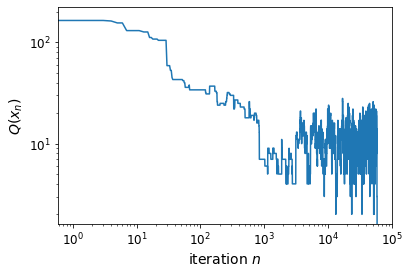

In [9]:
n = 5
mcmc, pracc, ok, success = MCMC(f, n, sim=10**6)

if success:
    print("--- SUCCESSFUL ---")
    print(
        f"It took {len(mcmc) - 1} iterations to find a magic square with magic number M = {int((n ** 3 + n) / 2)}\n"
    )
    print(mcmc[-1].reshape(n, n))
else:
    print("--- NOT SUCCESSFUL ---")

print(f"\nProbability of acceptance: {pracc.mean():.5f}")

q_values = [Q(x) for x in mcmc]
plt.loglog(q_values)
plt.xlabel(r"iteration $n$")
plt.ylabel(r"$Q(x_n)$");